# Homework 1 : CUAHSI VU : Snow Hydrology

We'll use the setup from the `homework_1_B_setup.ipynb` notebook for this exercise as well and we will use the forcing file with the rescaled wind from the `homework_1_C_exercise_1.ipynb` notebook. If you think that you comprised that setup in a previous exercise, just rerun `homework_1_B_setup.ipynb` and `homework_1_C_exercise_1.ipynb` before continuing.

## D. Homework 1 Exercise 2

### Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
import numpy as np # provide some mathematical functions
import xarray as xr # read, write, manipulate and analyze NetCDF files
from pathlib import Path
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
import pysumma as ps

#### Calculate incoming longwave radiation

**Calculation of vapor pressure from specific humidity**

Most methods for estimating incoming longwave radiation from other variables require some combination of air temperature, a measure of humidity (vapor pressure or specific humidity), and perhaps some other variables. First, we will derive the relationship between specific humidity and vapor pressure, since we have specific humidity as part of the SUMMA forcing file.

We begin with definitions of relative humidity and rearranging,

$$ RH = \frac{w}{w_s} = \frac{e}{e_s} \rightarrow e = \frac{e_s \cdot w}{w_s} $$

Given specific humidity as the mass mixing ratio of water vapor we can rearrange, 

$$q = \frac{w}{w+1} \rightarrow w = -\frac{q}{q-1}$$

And finally, using the conversion factor:

$$ w_s \approx 0.622 \frac{e_s}{p} $$

we are able to write the vapor pressure in terms of the specific humidity and air pressure:

$$ e = -\frac{e_s}{w_s}\left(\frac{q}{q-1}\right) \approx -1.607 \cdot p \left(\frac{q}{q-1}\right) $$

With this we can define a number of functions for estimating longwave radiation.

**Methods for estimating longwave radiation**

We define the following five functions for estimating longwave radiation (the references are provide in the functions): 
* Prata
* TVA
* Satterlund
* Anderson
* Dokia

For each of the functions, the units of the inputs are consistent with the units in the SUMMA forcing files. Note that there are also a few helper functions that are used by one or more of the methods.

In [2]:
# Stephan-Boltzmann constant (J/s/m^2/K^4)
STEFAN = 5.67e-8


def vapor_pressure(air_pressure, spec_humid):
    """See above for derivation"""
    return -1.607 * air_pressure * spec_humid / (spec_humid - 1)


def longwave_prata(air_temp, vapor_pressure):
    """
    Reference:
        Prata, A.J., 1996. A new long-wave formula for estimating
        downward clear-sky radiation at the surface. Q. J. R. Meteor.
        Soc. 122 (533), 1127–1151, doi:10.1002/qj.49712253306.
    """
    z = 46.5 * (vapor_pressure / air_temp)
    emissivity = 1 - (1 + z) * np.exp(-np.sqrt(1.2 + 3 * z))
    return emissivity * np.power(air_temp, 4) * STEFAN
        
    
def longwave_tva(air_temp, vapor_pressure):
    """
    Reference:
        Tennessee Valley Authority, 1972. Heat and mass transfer between a
        water surface and the atmosphere. Tennessee Valley Authority, Norris,
        TN. Laboratory report no. 14. Water resources research report no. 0-6803.
    """
    emissivity = 0.74 + 0.0049 * vapor_pressure/10
    return emissivity * np.power(air_temp, 4) * STEFAN


def longwave_satterlund(air_temp, vapor_pressure):
    """
    Reference:
        Satterlund, D.R., 1979. An improved equation for estimating long-wave
        radiation from the atmosphere. Water Resour. Res. 15 (6), 1649–1650,
        doi:10.1029/WR015i006p01649.
    """
    vp = vapor_pressure / 10
    emissivity = 1.08 * (1 - np.exp(-np.power(vp, air_temp/2016)))
    return emissivity * np.power(air_temp, 4) * STEFAN


def longwave_anderson(air_temp, vapor_pressure):
    """
    Referencce:
        Anderson, E.R., 1954. Energy budget studies, water loss
        investigations: lake Hefner studies. U.S. Geol. Surv. Prof. Pap. 269,
        71–119 [Available from U.S. Geological Survey, 807 National Center,
        Reston, VA 20192.].
    """
    emissivity = 0.68 + 0.036 * np.power(vapor_pressure/10, 0.5)
    return emissivity * np.power(air_temp, 4) * STEFAN


def cloud_correction(shortwave, lat=43.03, highlimit=0.6, lowlimit=0.35):
    """Converted from cloudfactor_Jessica.m"""
    doy = shortwave.time.dt.dayofyear
    s0 = 1360                     # Solar constant (W/m^2)
    phi = lat * 2 * np.pi / 365   # Convert to radian
    # Declination in radians
    delta = (2 * np.pi / 365) * (23.45 * np.sin(2 * np.pi * (284 + doy) / 365))
    
    # Top of atmosphere radiation
    hs = np.arccos(-np.tan(phi) * np.tan(delta))
    q0 = s0 * (1/np.pi) * (
        hs * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(hs))
    
    # Fraction of recieved radiation
    k = shortwave / q0
    
    # Cloud cover fraction
    cloud_frac = 1 - ((k - lowlimit) / (highlimit - lowlimit))
    cloud_frac = cloud_frac.where(cloud_frac > 0, other=0.0)
    cloud_frac = cloud_frac.where(cloud_frac < 1, other=1.0)
    return cloud_frac
    
    
def longwave_dokia(air_temp, vapor_pressure, shortwave):
    """
    References:
      -Clear sky:
        Dilley, A. C., and D. M. O<92>Brien (1998), Estimating downward clear sky
        long-wave irradiance at the surface from screen temperature and precipitable
        water, Q. J. R. Meteorol. Soc., 124, 1391<96> 1401.
      -Cloudy sky:
        Kimball, B. A., S. B. Idso, and J. K. Aase (1982), A model of thermal                                                                                          
        radiation from partly cloudy and overcast skies, Water Resour. Res., 18,                                                                                       
        931<96> 936.                                   
    """
    vp = vapor_pressure / 1000 # Convert to kPa
    w = 4560 * (vp / air_temp) # Prata (1996) approximation for precipitable water
    
    # Clear sky component of longwave
    lw_clear = 59.38 + 113.7 * np.power(air_temp / 273.16, 6) + 96.96 * np.sqrt(w / 25)
    
    # Cloud cover corrections
    c = cloud_correction(shortwave)
    cloud_temp = air_temp - 11
    winter = np.logical_or(vp.time.dt.month <= 2, vp.time.dt.month == 12)
    summer = np.logical_and(vp.time.dt.month <= 8, vp.time.dt.month >=6)
    cloud_temp[winter] -= 2
    cloud_temp[summer] += 2
    
    # Cloudy sky component of longwave
    eps8z = 0.24 + 2.98e-6 * np.power(vp, 2.0) * np.exp(3000/air_temp)
    tau8 = 1 - eps8z * (1.4 - (0.4 * eps8z))
    f8 = -0.6732 + 0.6240e-2 * cloud_temp - 0.914e-5 * np.power(cloud_temp, 2.0)
    lw_cloud = tau8 * c * f8 * STEFAN * np.power(cloud_temp, 4)   
    return lw_clear + lw_cloud

### Example

Create a SUMMA simulation object.

In [53]:
executable = 'summa.exe'
filemanager = '/home/jovyan/data/umpqua/settings/snow_fileManager_umpqua_rescaled_wind.txt'
s = ps.Simulation(executable, filemanager)

Open the forcing file for this simulation and read the file into an `xarray Dataset` object. Note that the name of the forcing file is stored in the forcing list file. The location of that file is given by:

In [54]:
print(s.force_file_list)

'Storck_AboveCanopyPP_9697_rescaled_wind.nc'


If you look in that file, you will see that the name of the forcing file is `Storck_AboveCanopyPP_9697_rescaled_wind.nc`. If it is something else, change it the same way we did in the previous notebook. Note that this assumes that the forcing file exists. It will if you have run through the previous notebook. The directory for that file is given by

In [5]:
print(s.force_file_list.prefix)

/home/jovyan/data/umpqua/forcing/


As before, we can view the forcing data as an `xarray Dataset`.

In [55]:
force_file_wind = s.force_file_list.options[0].name
force_wind = s.force_file_list.open_forcing_data()[0]

To examine the contents of the file, you can simply type the name of the `Dataset`

In [7]:
force_wind

<xarray.Dataset>
Dimensions:    (hru: 2, time: 1770)
Coordinates:
  * time       (time) datetime64[ns] 1996-11-25T21:59:59.999996640 ... 1997-0...
Dimensions without coordinates: hru
Data variables:
    hruId      (hru) int32 ...
    latitude   (hru) float64 ...
    longitude  (hru) float64 ...
    data_step  timedelta64[ns] ...
    LWRadAtm   (time, hru) float64 ...
    SWRadAtm   (time, hru) float64 ...
    airpres    (time, hru) float64 ...
    airtemp    (time, hru) float64 ...
    pptrate    (time, hru) float64 ...
    spechum    (time, hru) float64 ...
    windspd    (time, hru) float64 ...
Attributes:
    dataset_orig_path:  /d2/anewman/summa/summaTestCases/testCases_data/input...
    history:            Tue Sep 27 21:53:13 2016: ncrename -d nHRU,hru ./inpu...
    NCO:                "4.6.0"

To check that the winds are indeed different, we can quickly plot them

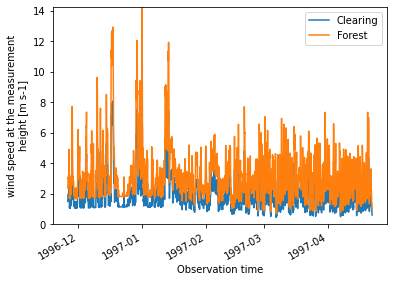

In [8]:
force_wind['windspd'].isel(hru=0).plot(label='Clearing')
force_wind['windspd'].isel(hru=1).plot(label='Forest')
plt.ylim(0,force_wind['windspd'].max())
plt.legend()

In this notebook we will examine different ways for estimating downward longwave, which we will assume is the same for the clearing and above the forest canopy (is that a reasonable assumption?). We can take a quick look at the downwelling longwave in the forcing file

**It depends on the clearing and how much influence from ground based objects there is**

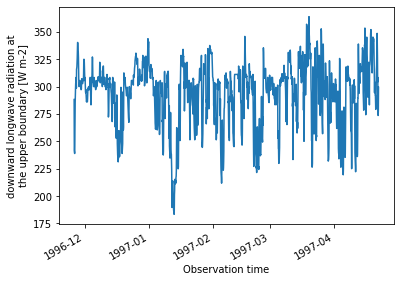

In [9]:
force_wind['LWRadAtm'].isel(hru=0).plot()

Now let's generate a new forcing dataset based on one of the longwave algorithms. Here we'll use Anderson as an example, which takes air temperature and vapor pressure as input (so we first need to calculate the vapor pressure). 

In [10]:
vp = vapor_pressure(force_wind['airpres'], force_wind['spechum'])
lw_anderson = longwave_anderson(force_wind['airtemp'], vp)

And let's plot the two different longwave time series for the first hru.

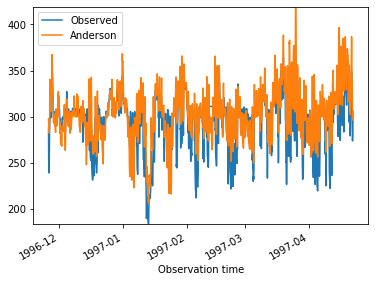

In [11]:
force_wind['LWRadAtm'].sel(hru=1).plot(label='Observed')
lw_anderson.sel(hru=1).plot(label='Anderson')
ymin = min(force_wind['LWRadAtm'].sel(hru=1).min(), lw_anderson.sel(hru=1).min())
ymax = max(force_wind['LWRadAtm'].sel(hru=1).max(), lw_anderson.sel(hru=1).max())
plt.ylim((ymin, ymax))
plt.legend()

We'll do a quick run with the rescaled wind forcings

In [12]:
s.run('local', run_suffix='rescaled_wind')

Finally, we'll write our new Anderson forcing to file and we will do simulations with the new longwave time series (the other forcings will remain unchanged).

Writing this to file, we'll use a few steps:
* copy the original forcing dataset to a new one
* replace the longwave values
* write a new forcing file
* replace the forcing file name in the forcing file list with the name of the new file

Once done we can just do the new simulation. Note that in this case we are re-using the existing simulation object `S`. We could use a somewhat different workflow here and create new simulation objects, but for now we recommend this workflow, because it is easy to get the input files mixed up. For details on each of the steps, see the previous notebook.

As in the previous notebook, we should now write out the new forcing data, create a new forcing file list that specifies that data, and finally a new file manager which points to that forcing file list. The process is the same as before. The next cell will write the new forcing data.

In [13]:
force_anderson = force_wind.copy(deep=True) # copy te original forcing dataset
force_anderson['LWRadAtm'].values = lw_anderson.values # replace the longwave values
force_file_obs = s.force_file_list.options[0].name
force_file_anderson = force_file_wind.replace('9697_rescaled_wind', '9697_anderson') # write a new forcing file
force_anderson.to_netcdf(force_file_anderson, format='NETCDF3_CLASSIC') # replace forcing file name with new name of file

Now that we have the data written to the NetCDF file we need to write out the new forcing file list so that SUMMA can find it. We will first set the forcing file list to use the new forcing file that we just wrote out. Then we will write this back out as a new forcing file list.

In [14]:
s.force_file_list.options[0].name = force_file_anderson
new_force_file = str(s.force_file_list.file_name).replace('.txt', '_anderson.txt')
s.force_file_list.file_name = Path(new_force_file) # forcing file list uses new forcing file we just wrote
s.force_file_list.write()

With our new forcing file list written out we will also write out a new file manager. This helps to keep all of our runs separated so that we can go back and compare them more easily. Just as with the forcing file list, we will update the entry for the forcing file list in the file manager, and then write that out to a new file.

In [15]:
fm = ps.FileManager(s.manager.original_path, s.manager.file_name) 
new_filemanager_name = str(fm.file_name).replace('.txt', '_anderson.txt')  # create new file manager with new name
fm['forcingListFile'] = new_force_file.split('/')[-1] # split saves file to list at / delimeters and gets last entry
fm.file_name = Path(new_filemanager_name) # save under new path
fm.path = fm.original_path # sets path
fm.write() # writes out file
new_filemanager = str(fm.path / fm.file_name) # saves path and file name

In [16]:
print(fm)

controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1996-11-28 00:00'
simEndTime                           '1997-04-22 02:00'
tmZoneInfo                           'localTime'
settingsPath                         '/home/jovyan/data/umpqua/settings/'
forcingPath                          '/home/jovyan/data/umpqua/forcing/'
outputPath                           '/home/jovyan/data/umpqua/output/'
decisionsFile                        'snow_zDecisions.txt'
outputControlFile                    'snow_zOutputControl.txt'
globalHruParamFile                   'snow_zLocalParamInfo.txt'
globalGruParamFile                   'snow_zBasinParamInfo.txt'
attributeFile                        'snow_zLocalAttributes.nc'
trialParamFile                       'snow_zParamTrial.nc'
forcingListFile                      'snow_zForcingFileList_rescaled_wind_anderson.txt'
initConditionFile                    'snow_zInitCond.nc'
outFilePrefix                        

Finally, we can run the simulation with the new file manager to explore how changing the longwave affects the simulation.

In [17]:
s_anderson = ps.Simulation(executable, new_filemanager)
s_anderson.run('local', run_suffix='lw_anderson')

In [21]:
swe_file = '/home/jovyan/data/umpqua/observations/Storck_9697_SWE_obs.nc'
swe_obs = xr.open_dataset(swe_file)

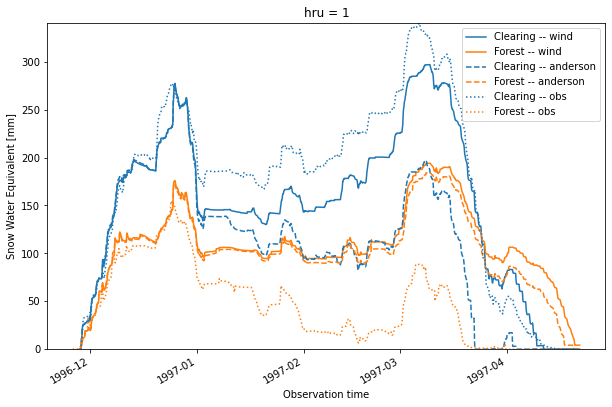

In [24]:
plt.figure(figsize=(10,6))
s.output['scalarSWE'].isel(hru=0).plot(label='Clearing -- wind', 
                                            color=cycle[0], linestyle='-')
s.output['scalarSWE'].isel(hru=1).plot(label='Forest -- wind',
                                            color=cycle[1], linestyle='-')
s_anderson.output['scalarSWE'].isel(hru=0).plot(label='Clearing -- anderson',
                                        color=cycle[0], linestyle='--')
s_anderson.output['scalarSWE'].isel(hru=1).plot(label='Forest -- anderson',
                                        color=cycle[1], linestyle='--')
swe_obs['SWE'].isel(hru=0).plot(label='Clearing -- obs',
                             color=cycle[0], linestyle='dotted')
swe_obs['SWE'].isel(hru=1).plot(label='Forest -- obs',
                             color=cycle[1], linestyle='dotted')
max_swe = max(s.output['scalarSWE'].max(), s_anderson.output['scalarSWE'].max(), swe_obs['SWE'].max())
plt.ylim(0,max_swe)
plt.legend()

Here we see a large change in the snow in the clearing and a much smaller change in the snow below the canopy. You should try remaking the plot with the observations super-imposed as well (see previous notebook).

**Keep in mind that the file with the forcing file list now points to the file with the Anderson longwave file. If you want to rerun with any other forcing you will need to make sure that the file reported in `forcing_file_list` points to the right input file.**

You can navigate to this file in the file browser to the left.

### Exercise

Now it is up to you. Use different empirical methods to estimate the incoming longwave irradiance and compare the simulations with each other. Document the impact on the simulated snowpack in a forest clearing and under a forest canopy.

In the next exercise we take this a step further, but for now we just want to ensure that you can create new longwave forcings, use them as input to SUMMA and compare the impacts of these changes on snow pack development.

Finally a few hints and things to keep in mind: It is easy to get confused with the model setup and the simulations. If you make changes to the forcings and the simulations do not change, make sure that your simulation object actually reads the right forcing file.

All the forcing files should end up in the directory : `/home/jovyan/data/umpqua/forcing/`
You can inspect that directory in the file browser to the left (you can also do that in a terminal if you are familiar with unix).

To make sure that the right file is actually being read, you can inspect the `forcing_file_list`, which is at:
`/home/jovyan/data/umpqua/settings/snow_zForcingFileList.txt`

Keep in mind that commands in a jupyter notebook can be executed in any order, but that that may affect the results. When things don't make sense, re-install the setup for homework 1 (execute the cells in `homework_1_B_setup.ipynb`) and rerun `homework_1_C_Exercise_1.ipynb` to rescale the wind speed above the forest. Then rerun this notebook. To make sure you start afresh, you should also restart the kernel (so there are no old versions in memory). You can do this by going to `Kernel --> Restart Kernel...` and re-executing the notebook cells or selecting `Kernel --> Restart Kernel and Run All Cells`. Normally you would not redo all the model simulations every time, but since the simulations are short, we'll use that method for now.

In [26]:
# calculate vapor pressure
vp = vapor_pressure(force_wind['airpres'], force_wind['spechum'])
# calculate longwave irradiance with different functions that depend solely on vapor pressure and air pressure
lw_prata = longwave_prata(force_wind['airtemp'],vp)
lw_tva = longwave_tva(force_wind['airtemp'],vp)
lw_satterlund= longwave_satterlund(force_wind['airtemp'],vp)

In [31]:
# calculate other values using shortwave radiation
shortwave = force_wind['SWRadAtm']
lw_dokia = longwave_dokia(force_wind['airtemp'],vp, shortwave)

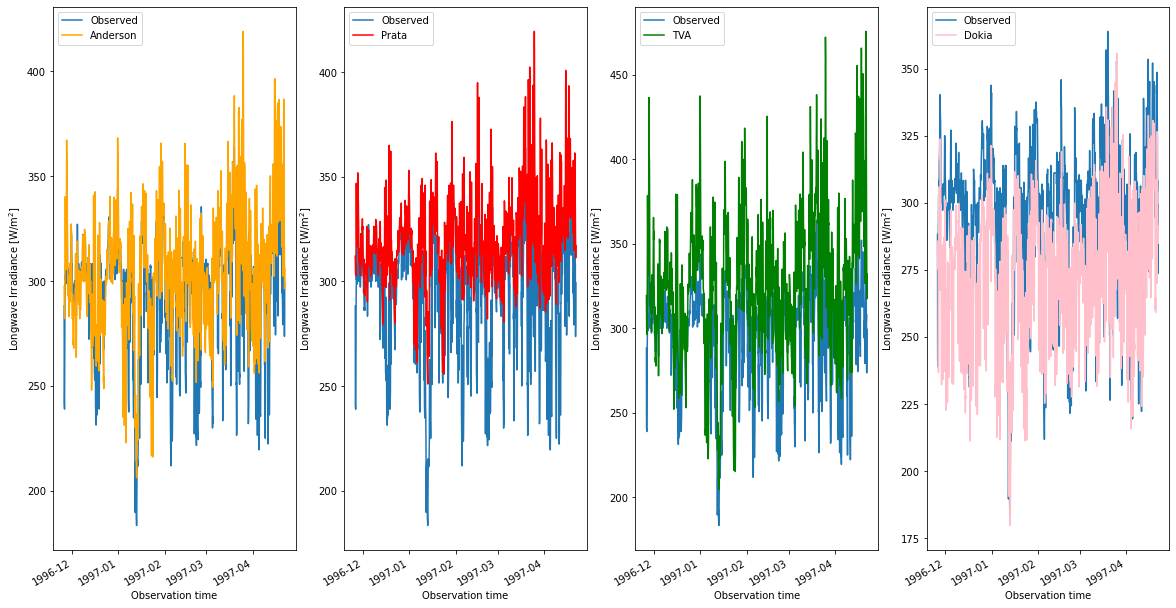

In [45]:
# adapted from cell above to show all lw calculations
fig,axs=plt.subplots(ncols=4, figsize=(20,10))

force_wind['LWRadAtm'].sel(hru=1).plot(ax=axs[0],label='Observed')
force_wind['LWRadAtm'].sel(hru=1).plot(ax=axs[1],label='Observed')
force_wind['LWRadAtm'].sel(hru=1).plot(ax=axs[2],label='Observed')
force_wind['LWRadAtm'].sel(hru=1).plot(ax=axs[3],label='Observed')
lw_anderson.sel(hru=1).plot(ax=axs[0],label='Anderson',c='orange')
lw_prata.sel(hru=1).plot(ax=axs[1],label='Prata',c='red')
lw_tva.sel(hru=1).plot(ax=axs[2],label='TVA',c='green')
lw_dokia.sel(hru=1).plot(ax=axs[3],label='Dokia',c='pink')
for ax in axs:
    ax.set_ylabel(r'Longwave Irradiance [W/m$^2$]')
    ax.legend()

In [60]:
def make_new_filemanager(new_name, new_force_file):
    # create new file manager
    fm = ps.FileManager(s.manager.original_path, s.manager.file_name) 
    new_filemanager_name = str(fm.file_name).replace('.txt', '_{}.txt'.format(new_name))  # create new file manager with new name
    fm['forcingListFile'] = new_force_file.split('/')[-1] # split saves file to list at / delimeters and gets last entry
    fm.file_name = Path(new_filemanager_name) # save under new path
    fm.path = fm.original_path # sets path
    fm.write() # writes out file
    new_filemanager = str(fm.path / fm.file_name) # saves path and file name
    return new_filemanager

'''new_name must be string
    returns filemanager
'''
def make_forcing_file_and_manager(new_name, new_forcing_data, to_replace='LWRadAtm'):
#     try:
    force_file_orig = s.force_file_list.options[0].name
    force_orig = s.force_file_list.open_forcing_data()[0]
    force_new = force_orig.copy(deep=True) # copy te original forcing dataset
    force_new[to_replace].values = new_forcing_data.values # replace the longwave values
    force_file_obs = s.force_file_list.options[0].name # save observations
    force_file_new = force_file_orig.replace('9697_rescaled_wind', '9697_'+new_name) # write a new forcing file
    force_new.to_netcdf(force_file_new, format='NETCDF3_CLASSIC') # replace forcing file name with new name of file

    s.force_file_list.options[0].name = force_file_new
    new_force_filename = str(s.force_file_list.file_name).replace('.txt', '_{}.txt'.format(new_name))
    s.force_file_list.file_name = Path(new_force_filename) # forcing file list uses new forcing file we just wrote
    s.force_file_list.write()

    filemanager = make_new_filemanager(new_name, new_force_filename)
    return filemanager
#     except:
#         print('Check that a simulation was run on the original dataset')
    

In [61]:
filemanager_prada = make_forcing_file_and_manager('prata', lw_prata, to_replace='LWRadAtm')

## On to the next step

That's it for the second part of the second homework as far as the model simulations go. Prof. Lundquist will talk more about the analysis that you need to do on these simulations. You can do the analysis here in this notebook if python is your analysis software of choice or you can upload your output to HydroShare (in NetCDF or csv format) to do additional analysis.

Save this notebook and close the tab. You can also right-click on the file in the left panel if it has a green dot next to it and select "_Shutdown kernel_" from the popup menu to stop the python session that is executing the commands in this notebook. Then open the next notebook: 
`/home/jovyan/data/cuahsi_vu/homework_1/homework_1_E_exercise_3.ipynb`.
